# **Autoencoder**

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
from torch.utils.data import DataLoader

from src.autoencoder.autoencoder import ConvAutoencoder
from src.data.dataset import get_split_image_files, SatelliteImageDataset

DATA_PATH = '../data/'
MAXAR_PRE_PATH = DATA_PATH + 'maxar_patches/pre/'
ENCODER_PATH = DATA_PATH + 'models/encoder.pth'

BATCH_SIZE = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Image.MAX_IMAGE_PIXELS = 303038464

In [32]:
train_image_files, test_image_files, val_image_files = get_split_image_files(MAXAR_PRE_PATH)

train_dataset = SatelliteImageDataset(image_files=train_image_files)
test_dataset = SatelliteImageDataset(image_files=test_image_files)
val_dataset = SatelliteImageDataset(image_files=val_image_files)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'✅ Train dataloader length: {len(train_dataloader)}')
print(f'✅ Test dataloader length: {len(test_dataloader)}')
print(f'✅ Val dataloader length: {len(val_dataloader)}')

✅ Train dataloader length: 1581
✅ Test dataloader length: 88
✅ Val dataloader length: 88


In [33]:
it = iter(train_dataloader)

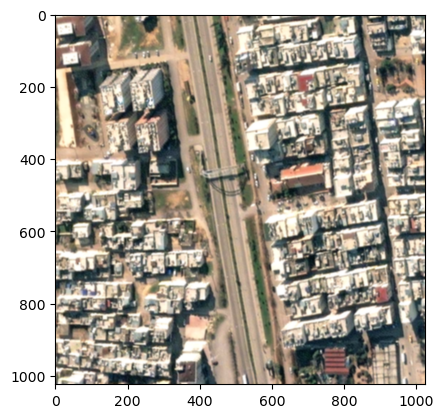

In [35]:
images = next(it)
image = images[0].permute(1, 2, 0)
plt.imshow(image)
plt.show()

In [36]:
autoencoder = ConvAutoencoder(
    encoder_channels=[3, 32, 64], 
    decoder_channels=[64, 32, 3],
    stride=2,
    kernel_size=3,
    padding=1,
    output_padding=1,
).to(DEVICE)
autoencoder.load_state_dict(torch.load(ENCODER_PATH))

<All keys matched successfully>

✅ Input image shape: torch.Size([1024, 1024, 3])


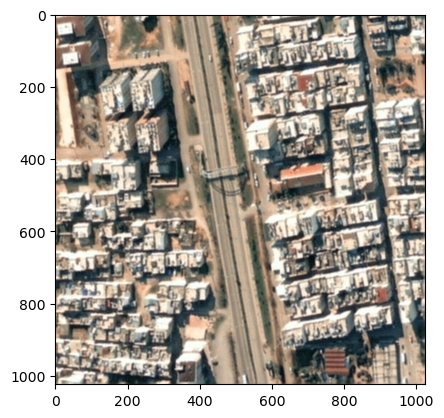

In [37]:
autoencoder.eval()
with torch.no_grad():
    input_image = images[0].unsqueeze(0).to(DEVICE)
    output_image = autoencoder(input_image)
    output_image = output_image.squeeze(0).permute(1, 2, 0).cpu()
    output_image = torch.clamp(output_image, 0, 1)

    print(f'✅ Input image shape: {output_image.shape}')

    plt.imshow(output_image)
    plt.show()

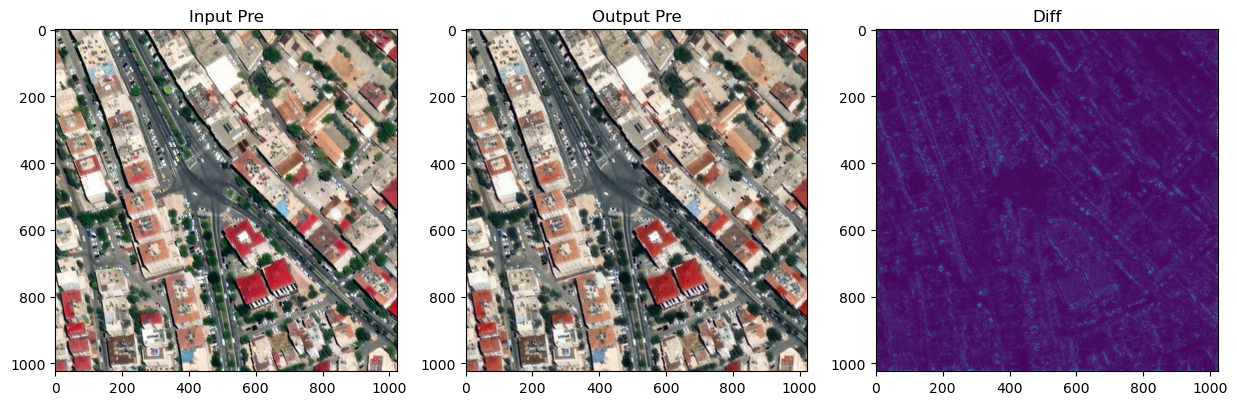

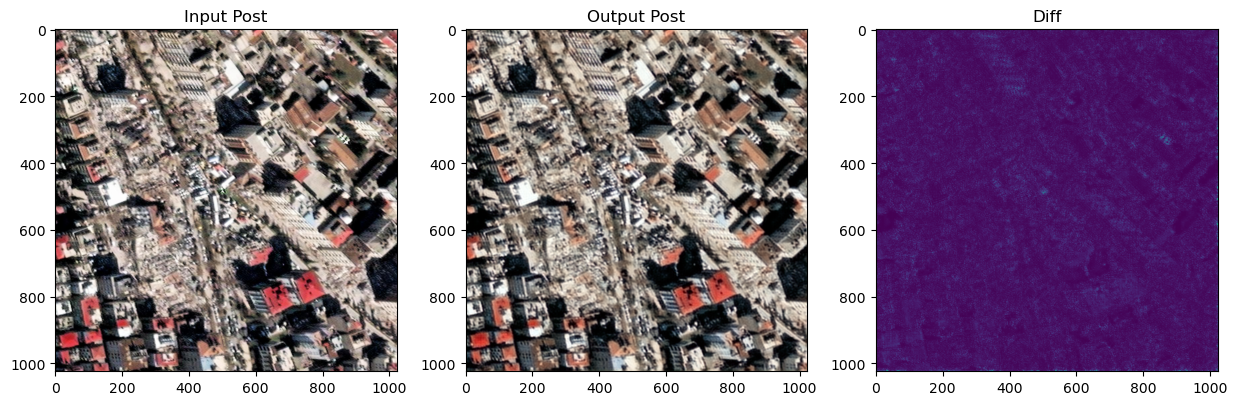

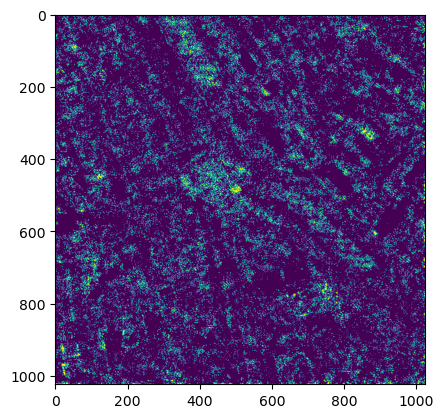

In [38]:
def get_input_image(image_path):
    image = np.array(Image.open(image_path)) / 255.
    image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    return image

def autoencode_image(autoencoder, input_image):
    autoencoder.eval()
    with torch.no_grad():
        output_image = autoencoder(input_image.to(DEVICE))
        output_image = torch.clamp(output_image, 0, 1)
    return output_image

def get_difference(input_image, output_image):
    diff = np.abs(input_image - output_image)
    diff = diff.sum(axis=2)
    norm_diff = diff / diff.max()

    return norm_diff

input_pre_image_path = '../data/maxar_patches/pre/031131233233_2022-07-26_10300100D797E100-visual_246.png'
input_pre_image = get_input_image(input_pre_image_path)

input_post_image_path = '../data/maxar_patches/post/031131233233_2023-02-08_10300500D9F8D200-visual_246.png'
input_post_image = get_input_image(input_post_image_path)

output_pre_image = autoencode_image(autoencoder, input_pre_image)
output_post_image = autoencode_image(autoencoder, input_post_image)

input_pre_image = input_pre_image.squeeze().permute(1, 2, 0).cpu()
input_post_image = input_post_image.squeeze().permute(1, 2, 0).cpu()
output_pre_image = output_pre_image.squeeze().permute(1, 2, 0).cpu()
output_post_image = output_post_image.squeeze().permute(1, 2, 0).cpu()

# Show
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_pre_image)
plt.title('Input Pre')
plt.subplot(1, 3, 2)
plt.imshow(output_pre_image)
plt.title('Output Pre')
plt.subplot(1, 3, 3)
plt.imshow(get_difference(input_pre_image, output_pre_image), vmin=0, vmax=1)
plt.title('Diff')
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(input_post_image)
plt.title('Input Post')
plt.subplot(1, 3, 2)
plt.imshow(output_post_image)
plt.title('Output Post')
plt.subplot(1, 3, 3)
plt.imshow(get_difference(input_post_image, output_post_image), vmin=0, vmax=1)
plt.title('Diff')
plt.show()

# get ratio of difference
diff_pre = get_difference(input_pre_image, output_pre_image)
diff_post = get_difference(input_post_image, output_post_image)
diff = (diff_post - diff_pre).clip(min=0)

plt.imshow(diff > 0.05)
plt.show()